In [20]:
# A couple installations to troubleshoot the code
# code help cred to: Amit Kumar Jaiswal from Kaggle kernels
!pip install imblearn
from imblearn.over_sampling import SMOTE
!pip install lightgbm

In [21]:
import gc
import numpy as np
import os
import operator
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import xgboost as xgb

In [22]:
# Import data, quick check if successful
train_df = pd.read_csv("train1.csv")
test_df = pd.read_csv('test1.csv')
train_df.head()
test_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [23]:
# compare train and test data, (basically the same number of columns)
print("Costa Rican Household Poverty Level Prediction -  rows:",train_df.shape[0]," columns:", train_df.shape[1])
print("Costa Rican Household Poverty Level Prediction -  rows:",test_df.shape[0]," columns:", test_df.shape[1])

Costa Rican Household Poverty Level Prediction -  rows: 9557  columns: 143
Costa Rican Household Poverty Level Prediction -  rows: 23856  columns: 142


In [24]:
train_df.isnull().values.any()



True

In [25]:
test_df.isnull().values.any()


True

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [27]:
train_df.isnull().values.sum(axis=0)

array([   0, 6860,    0,    0,    0,    0,    0,    0, 7342,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7928,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    5,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,    0,    0])

In [28]:
# OBtain summary statistics, and get a good feel for the data.
test_df_describe = test_df.describe()
test_df_describe

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
count,6.453000e+03,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,5730.000000,23856.000000,23856.000000,...,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000
mean,1.748726e+05,0.050679,4.955776,0.028421,0.992748,0.961603,0.240191,1.348517,0.416541,1.563967,...,34.454183,74.44974,1657.798080,19.113389,54.087232,3.885480,3.564751,4.171669,100.509220,1657.798080
std,1.567887e+05,0.219346,1.539753,0.166174,0.084850,0.192157,0.427208,0.694216,0.713255,0.990171,...,21.696245,76.99701,1753.603406,17.314597,77.312255,6.878967,6.668757,13.105989,89.211063,1753.603406
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,16.00000,256.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,256.000000
50%,1.400000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,32.000000,36.00000,1024.000000,16.000000,36.000000,1.000000,2.250000,0.444444,75.111115,1024.000000
75%,2.200000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,1.750000,1.000000,2.000000,...,51.000000,121.00000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,132.250000,2601.000000
max,2.852700e+06,1.000000,15.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.000000,7.000000,...,97.000000,441.00000,9409.000000,169.000000,441.000000,100.000000,169.000000,64.000000,1296.000000,9409.000000


In [29]:
test_df.isnull().values.sum(axis=0)

array([    0, 17403,     0,     0,     0,     0,     0,     0, 18126,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 19653,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,    31,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

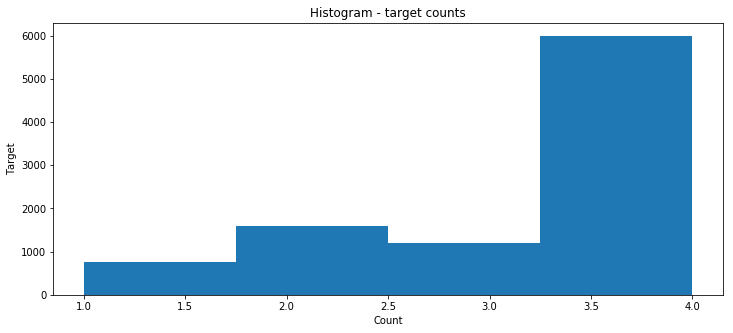

In [30]:
# Easyily viewable graphic of the target variable and distribution of target variable
plt.figure(figsize=(12, 5))
plt.hist(train_df.Target.values, bins=4)
plt.title('Histogram - target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

C:\Users\13852\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


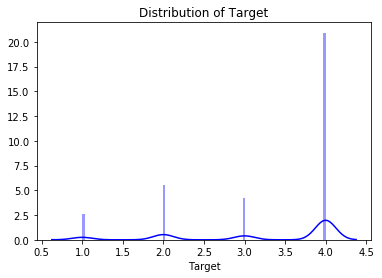

In [31]:
# Just another pretty graph that shows the distribution in a slightly different way.
plt.title("Distribution of Target")
sns.distplot(train_df['Target'].dropna(),color='blue', kde=True,bins=100)
plt.show()

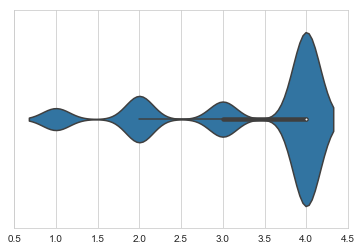

In [32]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train_df.Target.values)
plt.show()

In [35]:
# Unique values
np.unique(train_df.Target.values)

array([1, 2, 3, 4], dtype=int64)

In [36]:
columns_to_use = train_df.columns[1:-1]


In [37]:
# These are the determined important variables to use in predicting for this model.
columns_to_use


Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       'agesq'],
      dtype='object', length=141)

In [38]:
y = train_df['Target'].values-1


In [39]:
train_test_df = pd.concat([train_df[columns_to_use], test_df[columns_to_use]], axis=0)
# extract columns which data type is object
object_cols = [f_ for f_ in train_test_df.columns if train_test_df[f_].dtype == 'object']

In [40]:
# labeling
for col in object_cols:
    le = LabelEncoder()
    print(col)
    le.fit(train_test_df[col].astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
del le

idhogar
dependency
edjefe
edjefa


In [42]:
def dprint(*args, **kwargs):
    print("[{}] ".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")) + \
        " ".join(map(str,args)), **kwargs)

id_name = 'Id'
target_name = 'Target'

df_all = pd.concat([train_df, test_df], axis=0)
cols = [f_ for f_ in df_all.columns if df_all[f_].dtype == 'object' and f_ != id_name]
print(cols)

for c in tqdm(cols):
    le = preprocessing.LabelEncoder()
    le.fit(df_all[c].astype(str))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test[c].astype(str))

    del le
gc.collect()

def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms']

extract_features(train_df)
extract_features(test_df)

C:\Users\13852\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


[]


0it [00:00, ?it/s]


C:\Users\13852\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\13852\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


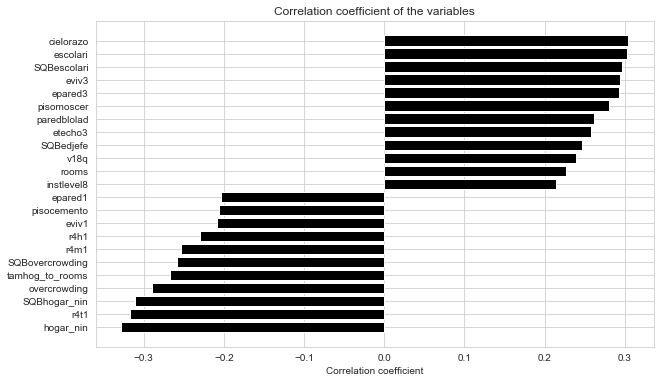

In [43]:
labels = []
values = []
for col in train_df.columns:
    if col not in ["Id", "Target"]:
        labels.append(col)
        values.append(np.corrcoef(train_df[col].values, train_df["Target"].values)[0,1])
corr_df = pd.DataFrame({'columns_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.20) | (corr_df['corr_values']<-0.20)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,6))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='black')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.columns_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

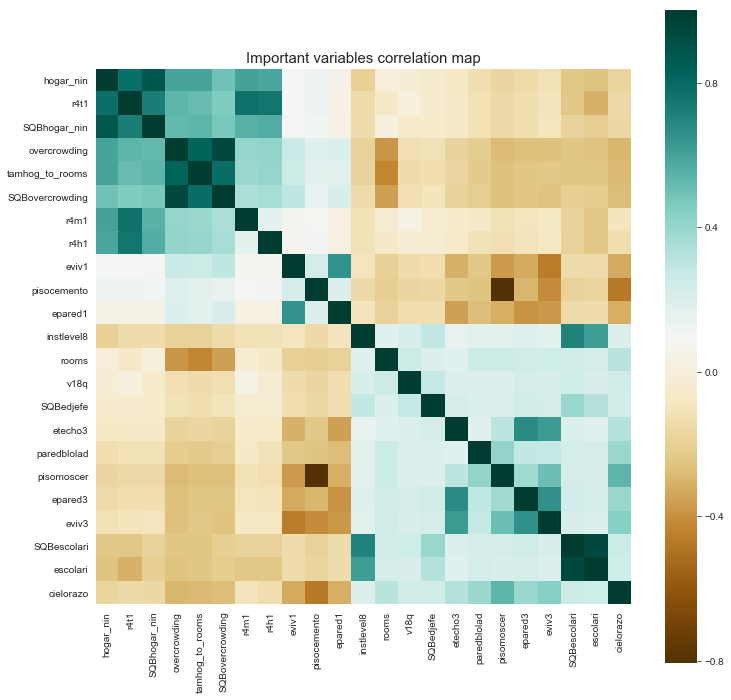

In [44]:
temp_df = train_df[corr_df.columns_labels.tolist()]
corrmat = temp_df.corr(method='pearson')
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=1., square=True, cmap=plt.cm.BrBG)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [45]:
cnt = 0
p_buf = []
n_splits = 20
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=None)
err_buf = []   

cols_to_drop = [
    id_name, 
    target_name,
]
X = train_df.drop(cols_to_drop, axis=1, errors='ignore')
feature_names = list(X.columns)
X = X.fillna(0)
X = X.values
y = train_df[target_name].values

classes = np.unique(y)
dprint('Number of classes: {}'.format(len(classes)))
c2i = {}
i2c = {}
for i, c in enumerate(classes):
    c2i[c] = i
    i2c[i] = c

y_le = np.array([c2i[c] for c in y])

X_test = test_df.drop(cols_to_drop, axis=1, errors='ignore')
X_test = X_test.fillna(0)
X_test = X_test.values
id_test = test_df[id_name].values
dprint(X.shape, y.shape)
dprint(X_test.shape)

n_features = X.shape[1]

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'max_depth': -1,
    'num_leaves': 14,
    'learning_rate': 0.1,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 8,
    'colsample_bytree': 0.89,
    'min_child_samples': 90,
    'subsample': 0.96,
    'lambda_l2': 1.0,
    'min_gain_to_split': 0,
    'num_class': len(np.unique(y)),
}

[2019-03-20 20:22] Number of classes: 4
[2019-03-20 20:22] (9557, 144) (9557,)
[2019-03-20 20:22] (23856, 144)


In [46]:
# Using a gradient boosting framework that uses tree based learning algorithms.
## lightgbm
sampler = RandomUnderSampler(random_state=314)
X, y = sampler.fit_sample(X, y)
y_le = np.array([c2i[c] for c in y])

for train_index, valid_index in kf.split(X, y):
    print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
    params = lgb_params.copy() 

    lgb_train = lgb.Dataset(
        X[train_index], 
        y_le[train_index], 
        feature_name=feature_names,
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X[valid_index], 
        y_le[valid_index],
        feature_name=feature_names,
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=99999,
valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=400, 
        verbose_eval=100, 
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(10):
            if i < len(tuples):
                print(i, tuples[i])
            else:
                break

        del importance, model_fnames, tuples

    p = model.predict(X[valid_index], num_iteration=model.best_iteration)

    err = f1_score(y_le[valid_index], np.argmax(p, axis=1), average='macro')

    dprint('{} F1: {}'.format(cnt + 1, err))

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)
    err_buf.append(err)

    cnt += 1

    del model, lgb_train, lgb_valid, p
    gc.collect

Fold 1/20*1
Training until validation scores don't improve for 400 rounds.
[100]	training's multi_logloss: 0.604436	valid_1's multi_logloss: 0.767606
[200]	training's multi_logloss: 0.384378	valid_1's multi_logloss: 0.635999
[300]	training's multi_logloss: 0.25542	valid_1's multi_logloss: 0.550278
[400]	training's multi_logloss: 0.175009	valid_1's multi_logloss: 0.510559
[500]	training's multi_logloss: 0.122924	valid_1's multi_logloss: 0.49034
[600]	training's multi_logloss: 0.0869919	valid_1's multi_logloss: 0.474024
[700]	training's multi_logloss: 0.0630047	valid_1's multi_logloss: 0.469303
[800]	training's multi_logloss: 0.046166	valid_1's multi_logloss: 0.467261
[900]	training's multi_logloss: 0.0345062	valid_1's multi_logloss: 0.473189
[1000]	training's multi_logloss: 0.0261809	valid_1's multi_logloss: 0.473669
[1100]	training's multi_logloss: 0.020176	valid_1's multi_logloss: 0.478115
Early stopping, best iteration is:
[771]	training's multi_logloss: 0.0503381	valid_1's multi_log

In [47]:
# error terms
err_mean = np.mean(err_buf)
err_std = np.std(err_buf)
print('F1 = {:.6f} +/- {:.6f}'.format(err_mean, err_std))
preds = p_buf/cnt

F1 = 0.825134 +/- 0.022751


In [48]:
print(preds)
preds = np.argmax(preds, axis = 1) +1
preds

[[0.02194  0.001172 0.010475 0.9663  ]
 [0.02441  0.001243 0.003529 0.97    ]
 [0.03442  0.001104 0.004856 0.961   ]
 ...
 [0.003378 0.796    0.1092   0.09155 ]
 [0.006176 0.6133   0.1956   0.1844  ]
 [0.005184 0.4583   0.4133   0.1234  ]]


array([4, 4, 4, ..., 2, 2, 2], dtype=int64)

In [50]:
# Final submission with preview.
sample_submission  = pd.read_csv("sample_submission1.csv")
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [53]:
sample_submission['Target'] = preds
sample_submission.to_csv('submission_{:.6f}.csv'.format(err_mean), index=False)
sample_submission

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,3
5,ID_e77d38d45,4
6,ID_3c5f4bd51,4
7,ID_a849c29bd,4
8,ID_472fa82da,4
9,ID_24864adcc,4


In [52]:
np.mean(preds)

3.103076794097921

In [ ]:
#important variables:
       # v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       #'r4h1', 'r4h2',
       #...
       #'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       #'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       #'agesq'

In [ ]:
#These were the parameters selected for the gradient boost:
  #   'boosting_type': 'gbdt',
  #   'objective': 'multiclass',
  #  'metric': 'multi_logloss',
  #  'max_depth': -1, # used this paramter to handle model overfitting.
  #  'num_leaves': 14,
  #  'learning_rate': 0.1, # used this because This determines the impact of each tree on the final outcome.
  #  'feature_fraction': 0.85, # used because boosting is random forest
  #  'bagging_fraction': 0.85, used this to speed up the training and avoid overfitting
  #  'bagging_freq': 5,
  #  'verbose': -1,
  #  'num_threads': 8,
  #  'colsample_bytree': 0.89,
  #  'min_child_samples': 90,
  #  'subsample': 0.96,
  #  'lambda_l2': 1.0, # to specify regulation
  #  'min_gain_to_split': 0, # This parameter will describe the minimum gain to make a split
  #  'num_class': len(np.unique(y)),
}

In [ ]:
# lgbm is a good model because it is used to handle model overfitting. ... 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.
# Light GBM can handle the large size of data and takes lower memory to run.

In [ ]:
# Because this model accurately shows that the data has been well understaood and then accounts for it in different ways, it can baseline be a good model to use.
# You can be comfortable using this with clients because it has been well tested and undertsood. And gradient boosting has beeen used to help predict the model. 
# You can go through the kernel and see the data and it will give oyu a feel for this good model.
# 